In [1]:
# Importing Necessary Libraries
import tensorflow
import google
import PIL
import matplotlib
import numpy
import pandas
import sklearn
import os
import glob

In [2]:
# Kaggle API Authentication
!pip install -q kaggle
google.colab.files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
# Downloading and Unzipping The Dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip

100% 5.19G/5.20G [01:47<00:00, 77.2MB/s]
100% 5.20G/5.20G [01:47<00:00, 51.9MB/s]


In [4]:
# Dataset Initialization
base_directory = os.path.join("/content")

image_paths = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob.glob(os.path.join(base_directory, '*', '*.jpg'))}

lesions = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-Like Lesions',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}     

dataset = pandas.read_csv(os.path.join(base_directory, 'HAM10000_metadata.csv'))

dataset['path'] = dataset['image_id'].map(image_paths.get)
dataset['cell_type'] = dataset['dx'].map(lesions.get) 
dataset['cell_type_idx'] = pandas.Categorical(dataset['cell_type']).codes

dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000_images_part_1/ISIC_0027419.jpg,Benign Keratosis-Like Lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000_images_part_1/ISIC_0025030.jpg,Benign Keratosis-Like Lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000_images_part_1/ISIC_0026769.jpg,Benign Keratosis-Like Lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000_images_part_1/ISIC_0025661.jpg,Benign Keratosis-Like Lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images_part_2/ISIC_0031633.jpg,Benign Keratosis-Like Lesions,2


In [5]:
# Checking For Empty Values
dataset.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [6]:
# Filling In Empty Values 
dataset['age'].fillna((dataset['age'].mean()), inplace = True)

In [7]:
# Checking for Empty Values 
dataset.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [8]:
# Reshaping Image Sizes to 75x100 To Prevent Exceeding RAM Limit
dataset['image'] = dataset['path'].map(lambda x: numpy.asarray(PIL.Image.open(x).resize((100, 75))))

In [24]:
# Dividing The Dataset Into Training and Testing Subsets
from sklearn.model_selection import train_test_split
training_dataset, testing_dataset = train_test_split(dataset, test_size = 0.1, random_state = 42)

In [25]:
training_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
9252,HAM_0001329,ISIC_0029650,nv,consensus,40.0,female,lower extremity,/content/ham10000_images_part_2/ISIC_0029650.jpg,Melanocytic Nevi,4,"[[[174, 135, 132], [180, 141, 139], [185, 147,..."
2157,HAM_0001791,ISIC_0027956,mel,histo,50.0,female,upper extremity,/content/HAM10000_images_part_1/ISIC_0027956.jpg,Melanoma,5,"[[[236, 186, 192], [242, 191, 197], [238, 188,..."
1147,HAM_0001177,ISIC_0025154,df,histo,55.0,male,upper extremity,/content/HAM10000_images_part_1/ISIC_0025154.jpg,Dermatofibroma,3,"[[[164, 133, 138], [165, 136, 138], [164, 131,..."
1747,HAM_0004853,ISIC_0034101,mel,histo,80.0,male,upper extremity,/content/ham10000_images_part_2/ISIC_0034101.jpg,Melanoma,5,"[[[16, 9, 11], [22, 11, 15], [37, 21, 26], [58..."
6329,HAM_0004650,ISIC_0028149,nv,follow_up,35.0,female,lower extremity,/content/HAM10000_images_part_1/ISIC_0028149.jpg,Melanocytic Nevi,4,"[[[225, 143, 159], [224, 144, 161], [223, 143,..."


In [26]:
testing_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,/content/ham10000_images_part_2/ISIC_0033272.jpg,Melanoma,5,"[[[155, 80, 110], [154, 76, 107], [153, 80, 11..."
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,/content/ham10000_images_part_2/ISIC_0031923.jpg,Melanocytic Nevi,4,"[[[213, 165, 169], [213, 169, 176], [214, 168,..."
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,/content/HAM10000_images_part_1/ISIC_0026652.jpg,Melanoma,5,"[[[203, 123, 122], [204, 124, 122], [206, 127,..."
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,/content/ham10000_images_part_2/ISIC_0030583.jpg,Benign Keratosis-Like Lesions,2,"[[[206, 150, 162], [205, 149, 161], [204, 147,..."
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,/content/ham10000_images_part_2/ISIC_0034010.jpg,Melanocytic Nevi,4,"[[[111, 89, 96], [118, 94, 99], [123, 100, 103..."


In [27]:
# Examining The Training Dataset Class Distribution
print("Training Dataset Class Distribution:\n\n{}".format(training_dataset["cell_type"].value_counts()))

Training Dataset Class Distribution:

Melanocytic Nevi                 6056
Melanoma                         1003
Benign Keratosis-Like Lesions     974
Basal Cell Carcinoma              467
Actinic Keratoses                 286
Vascular Lesions                  127
Dermatofibroma                    100
Name: cell_type, dtype: int64


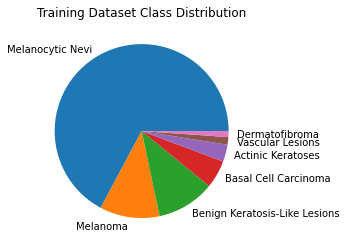

In [28]:
# Visualizing The Training Dataset Class Distribution
matplotlib.pyplot.figure() 
matplotlib.pyplot.pie(training_dataset["cell_type"].value_counts(), labels = ["Melanocytic Nevi", "Melanoma", "Benign Keratosis-Like Lesions", "Basal Cell Carcinoma", "Actinic Keratoses", "Vascular Lesions", "Dermatofibroma"])
matplotlib.pyplot.title("Training Dataset Class Distribution")
matplotlib.pyplot.show()

In [ ]:
classes = {0: "Actinic Keratoses",
           1: "Basal Cell Carcinoma",
           2: "Benign Keratosis-Like Lesions",
           3: "Dermatofibroma",
           4: "Melanocytic Nevi",
           5: "Melanoma",
           6: "Vascular Lesions"}

In [29]:
# Resampling The Training Dataset
akiec_samples = training_dataset[training_dataset["cell_type"] == "Actinic Keratoses"]
bcc_samples = training_dataset[training_dataset["cell_type"] == "Basal Cell Carcinoma"]
bkl_samples = training_dataset[training_dataset["cell_type"] == "Benign Keratosis-Like Lesions"]
df_samples = training_dataset[training_dataset["cell_type"] == "Dermatofibroma"]
nv_samples = training_dataset[training_dataset["cell_type"] == "Melanocytic Nevi"].sample(n = 2000, random_state = 42)
mel_samples = training_dataset[training_dataset["cell_type"] == "Melanoma"]
vasc_samples = training_dataset[training_dataset["cell_type"] == "Vascular Lesions"]

akiec_upsample = sklearn.utils.resample(akiec_samples, replace = True, n_samples = 1200, random_state = 42)
bcc_upsample = sklearn.utils.resample(bcc_samples, replace = True, n_samples = 1200, random_state = 42)
bkl_upsample = sklearn.utils.resample(bkl_samples, replace = True, n_samples = 1200, random_state = 42)
df_upsample = sklearn.utils.resample(df_samples, replace = True, n_samples = 1200, random_state = 42)
mel_upsample = sklearn.utils.resample(mel_samples, replace = True, n_samples = 2000, random_state = 42)
vasc_upsample = sklearn.utils.resample(vasc_samples, replace = True, n_samples = 1200, random_state = 42)

training_dataset = pandas.concat([akiec_upsample, bcc_upsample, bkl_upsample, df_upsample, nv_samples, mel_upsample, vasc_upsample])

In [30]:
training_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
9859,HAM_0004568,ISIC_0024463,akiec,histo,50.0,male,upper extremity,/content/HAM10000_images_part_1/ISIC_0024463.jpg,Actinic Keratoses,0,"[[[131, 104, 93], [134, 109, 101], [134, 109, ..."
9803,HAM_0004722,ISIC_0024575,akiec,histo,70.0,female,upper extremity,/content/HAM10000_images_part_1/ISIC_0024575.jpg,Actinic Keratoses,0,"[[[183, 124, 97], [185, 125, 99], [185, 121, 9..."
9909,HAM_0005648,ISIC_0027580,akiec,histo,75.0,male,upper extremity,/content/HAM10000_images_part_1/ISIC_0027580.jpg,Actinic Keratoses,0,"[[[195, 180, 187], [192, 177, 183], [189, 172,..."
9929,HAM_0004899,ISIC_0027930,akiec,histo,60.0,male,scalp,/content/HAM10000_images_part_1/ISIC_0027930.jpg,Actinic Keratoses,0,"[[[96, 57, 62], [94, 54, 56], [87, 55, 63], [1..."
9802,HAM_0003051,ISIC_0030175,akiec,histo,85.0,female,upper extremity,/content/ham10000_images_part_2/ISIC_0030175.jpg,Actinic Keratoses,0,"[[[183, 148, 166], [187, 154, 171], [188, 154,..."


In [31]:
# Examining The Updated Training Dataset Class Distribution
print("Updated Training Dataset Class Distribution:\n\n{}".format(training_dataset["cell_type"].value_counts()))

Updated Training Dataset Class Distribution:

Melanocytic Nevi                 2000
Melanoma                         2000
Dermatofibroma                   1200
Actinic Keratoses                1200
Vascular Lesions                 1200
Benign Keratosis-Like Lesions    1200
Basal Cell Carcinoma             1200
Name: cell_type, dtype: int64


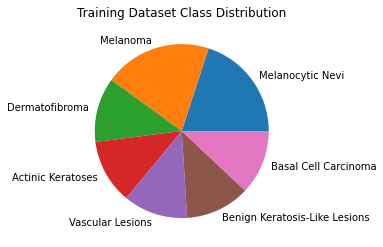

In [32]:
# Visualizing The Updated Training Dataset Class Distribution
matplotlib.pyplot.figure() 
matplotlib.pyplot.pie(training_dataset["cell_type"].value_counts(), labels = ["Melanocytic Nevi", "Melanoma", "Dermatofibroma", "Actinic Keratoses", "Vascular Lesions", "Benign Keratosis-Like Lesions", "Basal Cell Carcinoma"])
matplotlib.pyplot.title("Training Dataset Class Distribution")
matplotlib.pyplot.show()

In [36]:
# Dividing The Training And Testing Subsets Into Input And Output Arrays
X_train = numpy.asarray(training_dataset['image'].tolist())
X_test = numpy.asarray(testing_dataset['image'].tolist())

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_test = X_test.reshape(X_test.shape[0], *(75, 100, 3))

y_train = tensorflow.keras.utils.to_categorical(training_dataset["cell_type_idx"], num_classes = 7)
y_test = tensorflow.keras.utils.to_categorical(testing_dataset["cell_type_idx"], num_classes = 7)

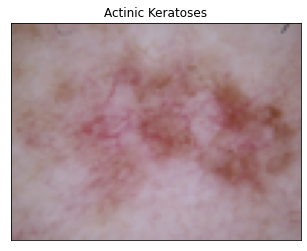

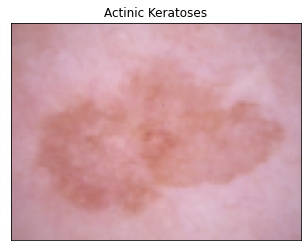

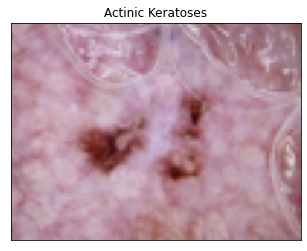

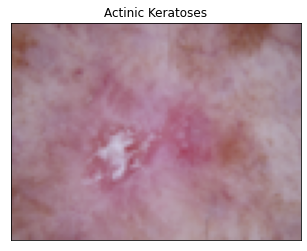

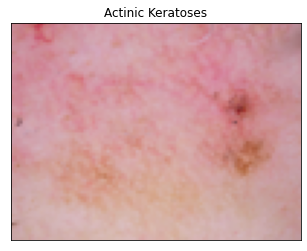

In [42]:
# Visualizing Actinic Keratoses
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[0])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Actinic Keratoses")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[200])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Actinic Keratoses")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[400])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Actinic Keratoses")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[600])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Actinic Keratoses")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[800])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Actinic Keratoses")
matplotlib.pyplot.show()

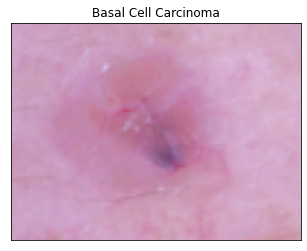

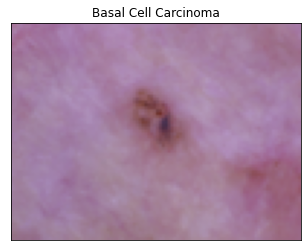

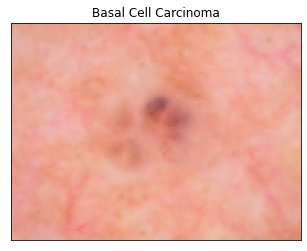

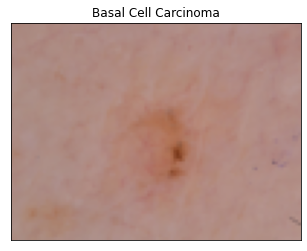

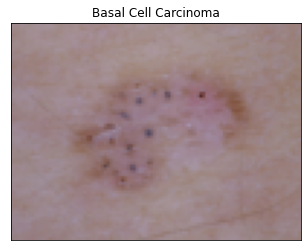

In [43]:
# Visualizing Basal Cell Carcinoma
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[1200])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Basal Cell Carcinoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[1400])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Basal Cell Carcinoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[1600])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Basal Cell Carcinoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[1800])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Basal Cell Carcinoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[2000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Basal Cell Carcinoma")
matplotlib.pyplot.show()

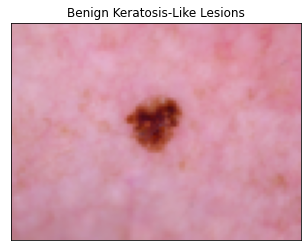

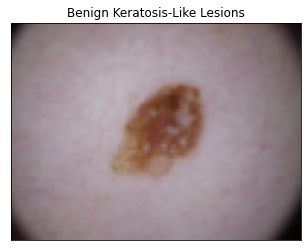

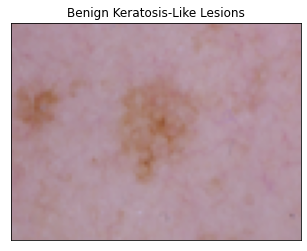

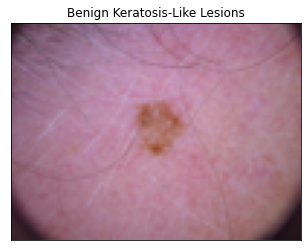

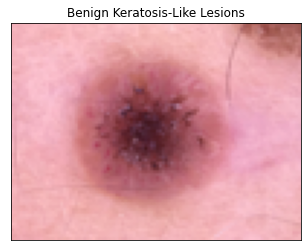

In [44]:
# Visualizing Benign Keratosis-Like Lesions
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[2400])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Benign Keratosis-Like Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[2600])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Benign Keratosis-Like Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[2800])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Benign Keratosis-Like Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[3000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Benign Keratosis-Like Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[3200])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Benign Keratosis-Like Lesions")
matplotlib.pyplot.show()

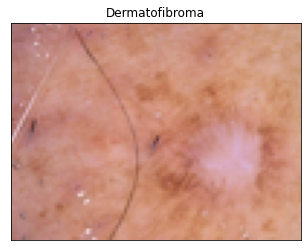

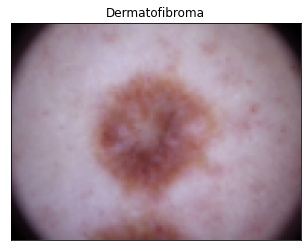

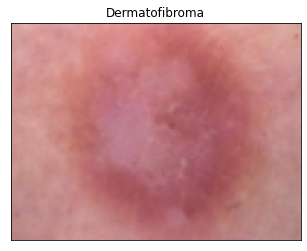

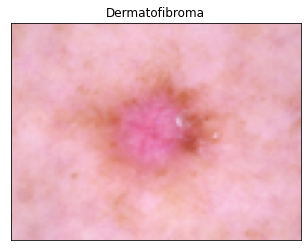

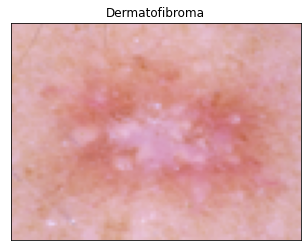

In [46]:
# Visualizing Dermatofibroma
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[3600])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Dermatofibroma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[3800])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Dermatofibroma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[4000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Dermatofibroma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[4200])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Dermatofibroma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[4400])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Dermatofibroma")
matplotlib.pyplot.show()

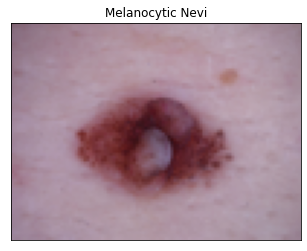

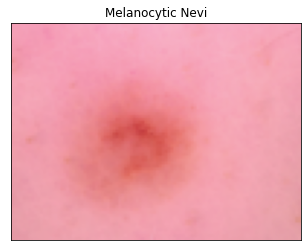

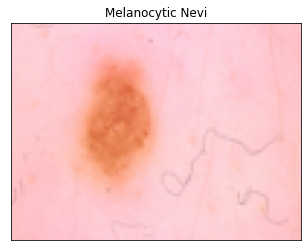

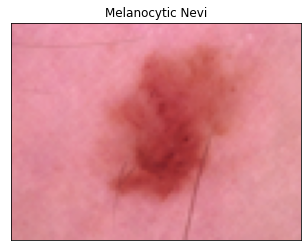

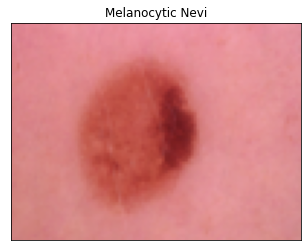

In [49]:
# Visualizing Melanocytic Nevi
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[4800])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanocytic Nevi")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[5000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanocytic Nevi")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[5200])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanocytic Nevi")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[5400])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanocytic Nevi")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[5600])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanocytic Nevi")
matplotlib.pyplot.show()

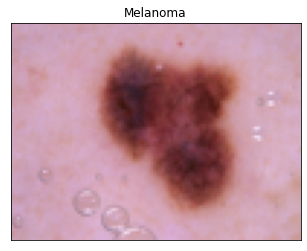

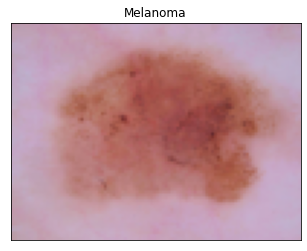

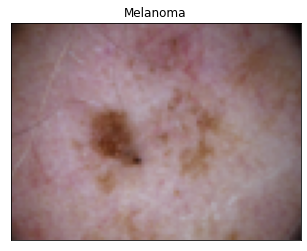

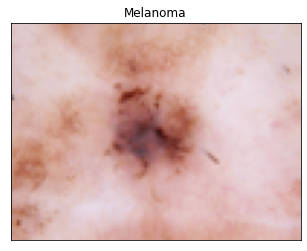

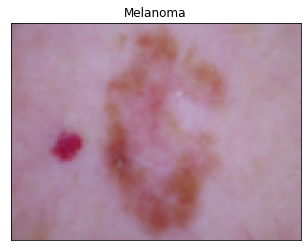

In [50]:
# Visualizing Melanoma
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[6800])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[7000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[7200])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[7400])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[7600])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanoma")
matplotlib.pyplot.show()

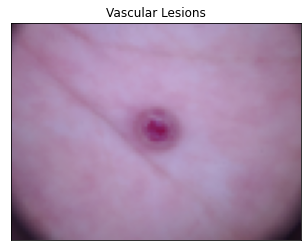

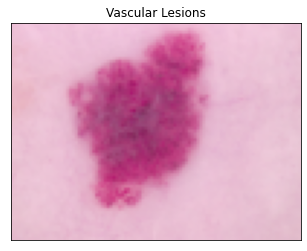

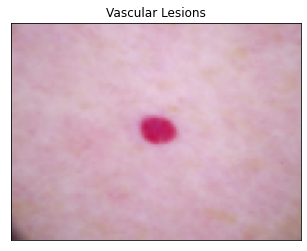

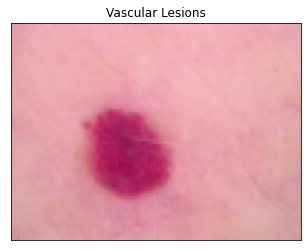

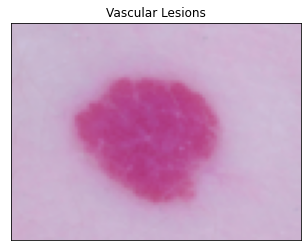

In [51]:
# Visualizing Vascular Lesions
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[8800])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Vascular Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[9000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Vascular Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[9200])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Vascular Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[9400])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Vascular Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[9600])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Vascular Lesions")
matplotlib.pyplot.show()

In [52]:
# Augmenting Training Data
image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
                  rotation_range = 45, 
                  width_shift_range = 0.5,
                  height_shift_range = 0.5,
                  zoom_range = 0.5,
                  horizontal_flip = True,
                  vertical_flip = True
)

training_image_generator = image_generator.flow(X_train, y_train)

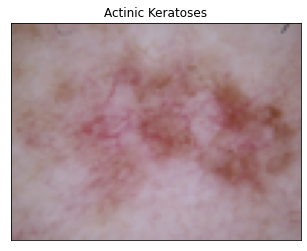

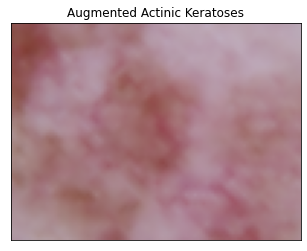

In [61]:
# Visualizing Augmented Actinic Keratoses
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[0])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Actinic Keratoses")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(training_image_generator.image_data_generator.apply_transform(X_train[0], transform_parameters = 
                                                                                       {"theta": 45,
                                                                                        "flip_horizontal": True,
                                                                                        "flip_vertical": True,
                                                                                        "tx": 0.5,
                                                                                        "ty": 0.5,
                                                                                        "zx": 0.5,
                                                                                        "zy": 0.5}))
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Augmented Actinic Keratoses")
matplotlib.pyplot.show()

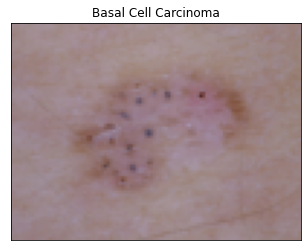

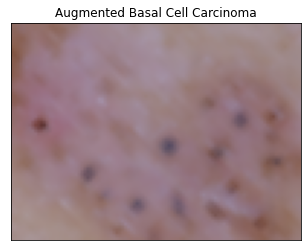

In [63]:
# Visualizing Augmented Actinic Keratoses
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[2000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Basal Cell Carcinoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(training_image_generator.image_data_generator.apply_transform(X_train[2000], transform_parameters = 
                                                                                       {"theta": 45,
                                                                                        "flip_horizontal": True,
                                                                                        "flip_vertical": True,
                                                                                        "tx": 0.5,
                                                                                        "ty": 0.5,
                                                                                        "zx": 0.5,
                                                                                        "zy": 0.5}))
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Augmented Basal Cell Carcinoma")
matplotlib.pyplot.show()

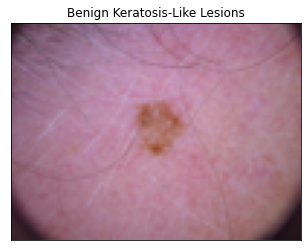

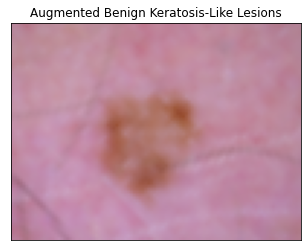

In [64]:
# Visualizing Augmented Benign Keratosis-Like Lesions
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[3000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Benign Keratosis-Like Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(training_image_generator.image_data_generator.apply_transform(X_train[3000], transform_parameters = 
                                                                                       {"theta": 45,
                                                                                        "flip_horizontal": True,
                                                                                        "flip_vertical": True,
                                                                                        "tx": 0.5,
                                                                                        "ty": 0.5,
                                                                                        "zx": 0.5,
                                                                                        "zy": 0.5}))
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Augmented Benign Keratosis-Like Lesions")
matplotlib.pyplot.show()

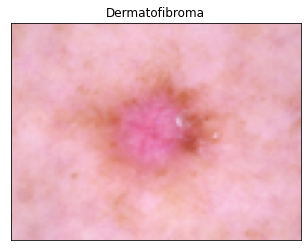

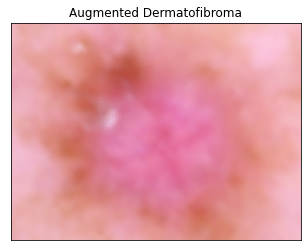

In [65]:
# Visualizing Augmented Dermatofibroma
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[4200])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Dermatofibroma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(training_image_generator.image_data_generator.apply_transform(X_train[4200], transform_parameters = 
                                                                                       {"theta": 45,
                                                                                        "flip_horizontal": True,
                                                                                        "flip_vertical": True,
                                                                                        "tx": 0.5,
                                                                                        "ty": 0.5,
                                                                                        "zx": 0.5,
                                                                                        "zy": 0.5}))
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Augmented Dermatofibroma")
matplotlib.pyplot.show()

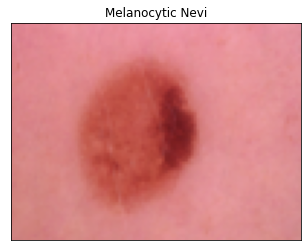

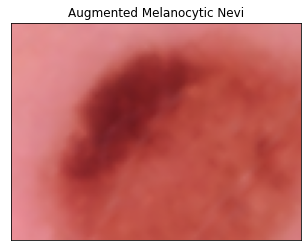

In [66]:
# Visualizing Augmented Melanocytic Nevi
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[5600])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanocytic Nevi")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(training_image_generator.image_data_generator.apply_transform(X_train[5600], transform_parameters = 
                                                                                       {"theta": 45,
                                                                                        "flip_horizontal": True,
                                                                                        "flip_vertical": True,
                                                                                        "tx": 0.5,
                                                                                        "ty": 0.5,
                                                                                        "zx": 0.5,
                                                                                        "zy": 0.5}))
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Augmented Melanocytic Nevi")
matplotlib.pyplot.show()

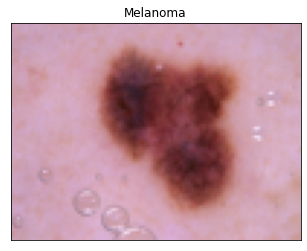

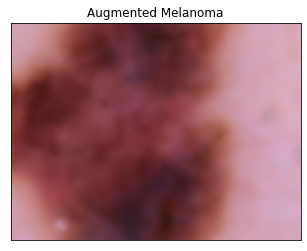

In [67]:
# Visualizing Augmented Melanoma
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[6800])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Melanoma")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(training_image_generator.image_data_generator.apply_transform(X_train[6800], transform_parameters = 
                                                                                       {"theta": 45,
                                                                                        "flip_horizontal": True,
                                                                                        "flip_vertical": True,
                                                                                        "tx": 0.5,
                                                                                        "ty": 0.5,
                                                                                        "zx": 0.5,
                                                                                        "zy": 0.5}))
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Augmented Melanoma")
matplotlib.pyplot.show()

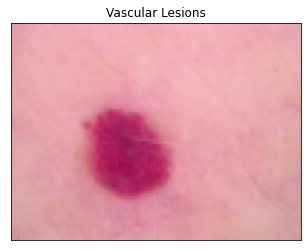

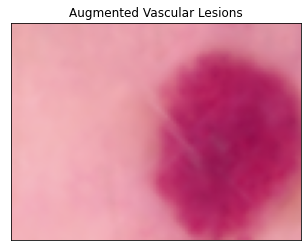

In [68]:
# Visualizing Augmented Vascular Lesions
matplotlib.pyplot.figure()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(X_train[9400])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Vascular Lesions")
matplotlib.pyplot.show()

matplotlib.pyplot.subplot()
matplotlib.pyplot.imshow(training_image_generator.image_data_generator.apply_transform(X_train[9400], transform_parameters = 
                                                                                       {"theta": 45,
                                                                                        "flip_horizontal": True,
                                                                                        "flip_vertical": True,
                                                                                        "tx": 0.5,
                                                                                        "ty": 0.5,
                                                                                        "zx": 0.5,
                                                                                        "zy": 0.5}))
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title("Augmented Vascular Lesions")
matplotlib.pyplot.show()